In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import os 
import pathlib 
import random
import matplotlib.image as mpimg
import zipfile
import wget
# import tensorflow_hub as hub
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
import tensorflow_datasets as tfds
import dlib

c:\anaconda3\envs\tf2.4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow.keras import mixed_precision

# Set the policy to mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650 SUPER, compute capability 7.5


In [4]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"

response = requests.get(url)
code = response.text

exec(code)

In [5]:
train_dir="FaceShape_Dataset/training_set/"
test_dir="FaceShape_Dataset/testing_set/"
lanmarks_dir="landmarks_women/"

In [6]:
import pathlib

data_dir = pathlib.Path(train_dir)
class_names=np.array(sorted([item.name for item in data_dir.glob('*')]))

print(class_names)

['Heart' 'Oblong' 'Oval' 'Round' 'Square']


In [7]:
# from struct import unpack
# from tqdm import tqdm
# import os

# images=os.listdir(train_dir+"square/")
# marker_mapping = {
#     0xffd8: "Start of Image",
#     0xffe0: "Application Default Header",
#     0xffdb: "Quantization Table",
#     0xffc0: "Start of Frame",
#     0xffc4: "Define Huffman Table",
#     0xffda: "Start of Scan",
#     0xffd9: "End of Image"
# }


# class JPEG:
#     def __init__(self, image_file):
#         with open(image_file, 'rb') as f:
#             self.img_data = f.read()
    
#     def decode(self):
#         data = self.img_data
#         while(True):
#             marker, = unpack(">H", data[0:2])
#             # print(marker_mapping.get(marker))
#             if marker == 0xffd8:
#                 data = data[2:]
#             elif marker == 0xffd9:
#                 return
#             elif marker == 0xffda:
#                 data = data[-2:]
#             else:
#                 lenchunk, = unpack(">H", data[2:4])
#                 data = data[2+lenchunk:]            
#             if len(data)==0:
#                 break        


# bads = []

# for img in tqdm(images):
#   image = os.path.join(train_dir+"square/",img)
#   image = JPEG(image) 
#   try:
#     image.decode()   
#   except:
#     bads.append(img)


# for name in bads:
#   os.remove(os.path.join(train_dir+"square/",name))

## PreProcessing

In [8]:
def jawline_detector(detections,img):
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    for detection in detections:
        shape = predictor(img, detection)
        jawline = list()
        for i in range(17):
            x = shape.part(i).x
            y = shape.part(i).y
            jawline.append((x, y))
        img_jaw =cv2.polylines(img, [np.array(jawline)], False, (0, 255, 0), 2)
    return jawline ,img_jaw ,shape 

In [9]:
def get_facial_landmarks(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    # Detect the face in the image
    face_rects = detector(image, 1)
    if len(face_rects) != 1:
        return None

    # Get the facial landmarks for the detected face
    shape = predictor(image, face_rects[0])
    landmarks = np.array([(shape.part(i).x, shape.part(i).y) for i in range(shape.num_parts)])

    return landmarks

In [10]:
labels=[]
images=[]
landmarks=[]

In [11]:
os.listdir(lanmarks_dir).__len__()

3993

In [12]:
from tqdm import tqdm
for i in tqdm(range(os.listdir(lanmarks_dir).__len__())):
    loaded_array = np.loadtxt(f'landmarks_women/row_{i}.txt', delimiter=',', dtype=int)
    landmarks.append(loaded_array)

  0%|          | 0/3993 [00:00<?, ?it/s]C:\Users\Ahmed Medhat\AppData\Local\Temp\ipykernel_4848\2225968264.py:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  loaded_array = np.loadtxt(f'landmarks_women/row_{i}.txt', delimiter=',', dtype=int)
C:\Users\Ahmed Medhat\AppData\Local\Temp\ipykernel_4848\2225968264.py:3: UserWarning: loadtxt: input contained no data: "landmarks_women/row_17.txt"
  loaded_array = np.loadtxt(f'landmarks_women/row_{i}.txt', delimiter=',', dtype=int)
C:\Users\Ahmed Medhat\AppData\Local\Temp\ipykernel_4848\2225968264.py:3: UserWarning: loadtxt: input contained 

In [13]:

count=0
for label in class_names:
    count+=1
    print(label,count)
    image_path=train_dir+label+"/"
    for image in tqdm(os.listdir(image_path)):
        try:
            image=image_path+image
            img=cv2.imread(image)
            img=cv2.resize(img, (224, 224))
            # landmarks.append(get_facial_landmarks(img))
            labels.append(label)
            images.append(img)
        except:
            continue    

Heart 1


100%|██████████| 799/799 [00:10<00:00, 77.98it/s] 


Oblong 2


100%|██████████| 797/797 [00:09<00:00, 80.37it/s] 


Oval 3


100%|██████████| 800/800 [00:09<00:00, 88.17it/s] 


Round 4


100%|██████████| 800/800 [00:10<00:00, 73.71it/s] 


Square 5


100%|██████████| 798/798 [00:09<00:00, 86.77it/s] 


In [14]:
landmarks.__len__(),images.__len__(),labels.__len__()

(3993, 3993, 3993)

In [15]:
landmarks_array=np.array(landmarks)
images_array=np.array(images)
labels_array=np.array(labels)

C:\Users\Ahmed Medhat\AppData\Local\Temp\ipykernel_4848\361443694.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  landmarks_array=np.array(landmarks)


In [16]:
landmarks_array.__len__(),images_array.__len__(),labels_array.__len__()

(3993, 3993, 3993)

In [20]:
for i in range(landmarks_array.__len__()):
     if landmarks_array[i].__len__()==0:
        landmarks_array=np.delete(landmarks_array, i)
        images_array=np.delete(images_array,i,axis=0)
        labels_array=np.delete(labels_array,i)
        print("Error at index: ",i)
        

In [21]:
landmarks_array.__len__(),images_array.__len__(),labels_array.__len__()

(3721, 3721, 3721)

In [28]:
lise=[]
lise.append([(i+20,i+30) for i in range(10)])
lise.append([(i+40,i+100) for i in range(10)])


In [31]:
lise=np.array(lise)

In [34]:
lise[1]

array([[ 40, 100],
       [ 41, 101],
       [ 42, 102],
       [ 43, 103],
       [ 44, 104],
       [ 45, 105],
       [ 46, 106],
       [ 47, 107],
       [ 48, 108],
       [ 49, 109]])

Text(0.5, 1.0, 'Oval')

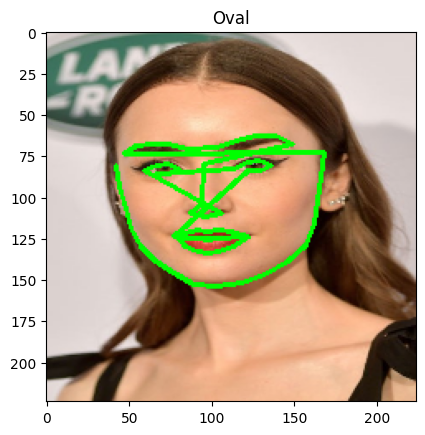

In [27]:

image_full=cv2.polylines(images[2000], [np.array(landmarks[2000])], False, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image_full, cv2.COLOR_BGR2RGB))
plt.title(labels[2000])

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# IMG_SIZE=(224,224)
# BATCH_SIZE=20

# train_data=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
#                                 shuffle=False,
#                              label_mode="categorical" ,
#                              image_size=IMG_SIZE,
#                              batch_size=BATCH_SIZE
#                              )


# test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
#                                                           shuffle=True,
#                              label_mode="categorical" ,
#                              image_size=IMG_SIZE,
#                              batch_size=BATCH_SIZE
#                              )

In [ ]:
# from tensorflow.keras.layers.experimental import preprocessing
# # Create data aug

# data_augmentation= tf.keras.Sequential([
#     preprocessing.RandomFlip("horizontal"),
#     preprocessing.RandomRotation(0.2),
#     preprocessing.RandomZoom(0.2),
#     preprocessing.RandomHeight(0.2),
#     preprocessing.RandomWidth(0.2),
    
# ],name="data_augmentation")

In [ ]:

# from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Concatenate
# # Create base model with tf.keras.applications

# base_model=tf.keras.applications.ResNet50(include_top=False)

# # Freeze the base model =>underlying pre-trained patterns aren't updated

# base_model.trainable=False

# # Create inputs into our model

# # # Freeze all layers except last 10 
    
# # for layer in base_model.layers[:-15]:
# #     layer.trainable=False

# # Define the input shapes
# image_input = Input(shape=(224, 224, 3))
# landmarks_input = Input(shape=(68, 2))

# # Normalize in case of using (ResNet50v2)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image_input)

# # # Data augmentation layer
# # x= data_augmentation(inputs)

# x=base_model(x)

# # Average the outputs 

# x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# x = Flatten()(x)
# image_output = Dense(units=128, activation='relu')(x)

# # Define the landmarks branch of the model
# y = Flatten()(landmarks_input)
# landmarks_output = Dense(units=128, activation='relu')(y)

# # Concatenate the outputs of the two branches
# z = Concatenate()([image_output, landmarks_output])
# # Create the output activation layer

# outputs = tf.keras.layers.Dense(5,activation="softmax",name="output_layer")(z)

# # Combine inputs with outputs 

# model_1 = tf.keras.Model(inputs=[image_input, landmarks_input],outputs=outputs)

In [ ]:
# model_1.compile(loss="categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                      metrics=["accuracy"])

In [ ]:
# model_1_history=model_1.fit(x=[images, landmarks], y=labels, batch_size=16, epochs=5
#          )

In [23]:
# Convert to array

images_array_16=np.asarray(images_array).astype('float16').reshape(-1,224,224,3)

#Normalization 
images_array_16=images_array_16/255

In [24]:
images_array_16.shape

(3721, 224, 224, 3)

In [26]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input shapes
image_input = Input(shape=(224, 224, 3))
landmarks_input = Input(shape=(68, 2))

# Define the image branch of the model
x = Conv2D(filters=32, kernel_size=3, activation='relu')(image_input)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = Flatten()(x)
image_output = Dense(60, activation='relu')(x)

# Define the landmarks branch of the model
y = Flatten()(landmarks_input)
landmarks_output = Dense(128, activation='relu')(y)

# Concatenate the outputs of the two branches
z = Concatenate()([image_output, landmarks_output])

# Define the output layer of the model
output = Dense(units=5, activation='softmax')(z)

# Define the model
model = Model(inputs=[image_input, landmarks_input], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Train the model
model.fit(x=[images_array_16, landmarks_array], y=labels_array, batch_size=8, epochs=5)


ResourceExhaustedError: OOM when allocating tensor with shape[3097600,60] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
plot_loss_curves(model_1_history)

In [ ]:
# import keras
# def myModel():
#     input = keras.Input(shape= (224,224,3))
#     x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
#     x= data_augmentation(input)
#     x = keras.layers.Conv2D(64, (3, 3), activation='relu',)(input)
#     x = keras.layers.MaxPooling2D((2, 2))(x)
#     x = keras.layers.Dropout(0.2)(x)
#     x = keras.layers.Conv2D(64, (3, 3), activation='relu',)(x)
#     x = keras.layers.MaxPooling2D((2, 2))(x)
#     x = keras.layers.Dropout(0.2)(x)
#     x = keras.layers.Conv2D(128, (3, 3), activation='relu',)(x)
#     x = keras.layers.MaxPooling2D((2, 2))(x)
#     x = keras.layers.Dropout(0.2)(x)
#     # x = keras.layers.Conv2D(512, (3, 3), activation='relu',)(x)
#     # x = keras.layers.MaxPooling2D((2, 2))(x)
#     # x = keras.layers.Dropout(0.4)(x)
#     x = keras.layers.Flatten()(x)
#     # x = keras.layers.Dense(1042, activation='relu',)(x)
#     # x = keras.layers.Dense(4012, activation='relu',)(x)
#     x = keras.layers.Dense(200, activation='relu',)(x)
#     # x = keras.layers.Dropout(0.4)(x)
#     out1 = keras.layers.Dense(4, activation='softmax',name='Char1')(x)
#     model = keras.models.Model(inputs=input,outputs=[out1,
                                                     
#                                                      ])
#     return model



# model =myModel()



# model.compile(
#     optimizer=tf.keras.optimizers.Adam(
#         learning_rate=0.0001
#         ),loss='categorical_crossentropy',metrics=['accuracy'])


# model_2_history=model.fit(
#     train_data,
#     steps_per_epoch=len(train_data),
#     validation_data = test_data,
#     epochs=8,
#     validation_steps=len(test_data)
#     )

## Over Fitting

In [ ]:
# plot curves 
plot_loss_curves(model_2_history)

In [ ]:
model.evaluate(test_data)

In [ ]:
pred_and_plot(model,"FaceShape_Dataset/testing_set/Oblong/oblong (106).jpg",224,class_names)

In [ ]:
def load_and_prep_image(filename, img_shape,scale=True):
    img=tf.io.read_file(filename)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.resize(img,size=[img_shape,img_shape])
    if scale:
        return img/255.
    else:
        return img

In [ ]:
img=load_and_prep_image("FaceShape_Dataset/testing_set/Heart/heart (365).jpg",img_shape=224)
    
pred=model.predict(tf.expand_dims(img,axis=0))
pred

In [ ]:
class_names

In [ ]:
pred_class=class_names[np.argmax(pred)]
pred_class

In [ ]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
model =build_model()



model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,decay=1e-5
        ),loss='categorical_crossentropy',metrics=['accuracy'])


model_2_history=model.fit_generator(
    train_data,
    steps_per_epoch=20,
    validation_data = test_data,
    epochs=8,
    validation_steps=20
    )